# Fine-tuning Bert with PrivacyQA

In this experiment, we download, tokenize, and train a 🤗 Transformers model on the PrivacyQA question/answering data. This task takes the text of a privacy-related question asked by a user and requires the model to predict whether the sentiment of the review is positive or negative.

# Imports / Dependencies

In [ ]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

!pip install textattack # TextAttack installation (package for text attacks)
!pip install torch==1.6 # need torch 1.6 for the augmenter to work

     |████████████████████████████████| 748.8MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
import numpy as np
from google.colab import drive
import transformers
from transformers import DistilBertTokenizerFast, DistilBertModel, BertConfig, DistilBertPreTrainedModel
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle
import textattack

making sure torch is 1.6 (need 1.6 for the augmenter otherwise might throw error)

In [ ]:
torch.__version__

'1.6.0'

# Load the Clean Data (no adversarial examples)

Mount google drive

In [ ]:
!rm -rf ./sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Read in the PrivacyQA dataset from google drive (assuming you have a shortcut to the 'privacyQA_dataset' directory under 'MyDrive')

In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/privacyQA_dataset/train_opp_annotations')
test_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/privacyQA_dataset/test_opp_annotations')
print(train_set.head())
print(test_set.head())

                                 Folder  ... other
0  ../../Dataset/Train/com.cake.browser  ...     0
1  ../../Dataset/Train/com.cake.browser  ...     0
2  ../../Dataset/Train/com.cake.browser  ...     0
3  ../../Dataset/Train/com.cake.browser  ...     0
4  ../../Dataset/Train/com.cake.browser  ...     0

[5 rows x 12 columns]
                                 Folder      DocID  ... audiences unknown
0  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
1  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
2  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
3  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
4  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0

[5 rows x 14 columns]


Drop the unnecessary columns ('audiences' and 'unknown') from the test set.

In [ ]:
test_set = test_set.drop(['audiences', 'unknown'], axis=1)
print(test_set.head())

                                 Folder      DocID  ... user_choice other
0  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
1  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
2  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
3  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
4  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0

[5 rows x 12 columns]


# Preprocess the Data & Create train-val-test split

Now let's create sets of inputs (query texts) and labels (onehot-encoded) out of the train and test sets.

In [ ]:
def read_pqa_split(dataset):
    """ assumes `dataset` is a pandas DataFrame """
    texts = dataset.Query.to_list()
    label_cols = dataset.columns[5:]
    labels = dataset[label_cols].values.tolist() # onehot-encoded labels
    return texts, labels

train_texts, train_labels = read_pqa_split(train_set)
test_texts, test_labels = read_pqa_split(test_set)

Let's check the class distribution in the training set 

In [ ]:
np.array(train_labels).sum(axis=0)

array([619, 323, 153,  85,  31,  88,  20])

We now have a train and test dataset, but let's also also create a validation set which we can use for evaluation
and tuning without tainting our test set results. Sklearn has a convenient utility for creating such splits:

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=42) 

# Augment train_texts with adversarial examples

Load the training 

Create a TextAttack augmenter based on "BAE: BERT-based Adversarial Examples for Text Classification."

In [ ]:
augmenter = textattack.augmentation.recipes.WordNetAugmenter(
    pct_words_to_swap=0.1, 
    transformations_per_example=1
    )

Check that the augmenter works

In [ ]:
s = "will other companies have access to my info?"
augmenter.augment(s)

['will other party have access to my info?']

Augment the train set

In [ ]:
print('Size of train_texts before data augmentation', len(train_texts))
train_texts += [augmenter.augment(s)[0] for s in train_texts]
print('Size of train_texts after data augmentation', len(train_texts))

Size of train_texts before data augmentation 1080
Size of train_texts after data augmentation 2160


In [ ]:
print('original example:', train_texts[0])
print('augmented example:', train_texts[0 + 1080])

original example: will my information be shared with anyone?
augmented example: will my data be shared with anyone?


## Tokenization

Alright, we've read in our dataset, created a train-val-test split, and augmented the train set with adversarial examples. Now let's tackle tokenization. We'll eventually train a classifier using
pre-trained DistilBert, so let's use the DistilBert tokenizer.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased')

Now we can simply pass our texts to the tokenizer. We'll pass `truncation=True` and `padding=True`, which will
ensure that all of our sequences are padded to the same length and are truncated to be no longer model's maximum input
length. This will allow us to feed batches of sequences into the model at the same time.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Now, let's turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a
`torch.utils.data.Dataset` object and implementing `__len__` and `__getitem__`. In TensorFlow, we pass our input
encodings and labels to the `from_tensor_slices` constructor method. We put the data in this format so that the data
can be easily batched such that each key in the batch encoding corresponds to a named parameter of the
`DistilBertForSequenceClassification.forward` method of the model we will train.

In [ ]:
class PqaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PqaDataset(train_encodings, train_labels)
val_dataset = PqaDataset(val_encodings, val_labels)
test_dataset = PqaDataset(test_encodings, test_labels)

Now that our datasets our ready, we can fine-tune a model either with the 🤗
`Trainer`. See [training](https://huggingface.co/transformers/training.html).

# Fine-tuning with the `Trainer` module

The steps above prepared the datasets in the way that the trainer is expecting. Now all we need to do is create a model
to fine-tune, define the `TrainingArguments`/`TFTrainingArguments` and
instantiate a `Trainer`/`TFTrainer`.

Importantly, we need to subclass the Trainer class to make it suitable for multilabel classification (by default it is suited for **_multiclass_** classification, which is different and not waht we want here). The extended class was taken from the example at https://huggingface.co/transformers/main_classes/trainer.html#codecell0.

First, we need to subclass and adapt the original DistilBert for multi-label calssification --

In [ ]:
class DistilBertForMultilabelSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.pre_classifier = torch.nn.Linear(config.dim, config.dim)
        self.classifier = torch.nn.Linear(config.dim, config.num_labels)
        self.dropout = torch.nn.Dropout(config.seq_classif_dropout)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = torch.nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # the onlny modification to the original DistilBert is below
                loss_fct = torch.nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.distilbert.config.num_labels),
                                labels.float().view(-1, self.distilbert.config.num_labels))

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

In [ ]:
output_dir = '/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/robust_model_20_epochs'

Then, we can instantiate the model and train it --- 

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention', 'user_access', 'user_choice', 'other']

training_args = TrainingArguments(
    output_dir=output_dir, # output directory for model predictions and checkpoints
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=10,
    logging_dir=output_dir+'/logs',
    load_best_model_at_end=True, # will save/checkpoint the model after every evaluation
    evaluation_strategy="epoch", # will evaluate every epoch
    # DO NOT USE # label_names=label_names,  # DO NOT USE THIS --- THROWS ERROR
)

NUM_LABELS = len(label_names)
model = DistilBertForMultilabelSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=NUM_LABELS,
    id2label=dict(enumerate(label_names)), # use to show text labels
    )

# Customized Trainer class for Multi-label classification
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

trainer = MultilabelTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
)

# Start the training
trainer.train()
# Save model
model.save_pretrained(output_dir)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultilabelSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultilabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

save log

In [ ]:
log = b"""Epoch	Training Loss	Validation Loss
1	0.593500	0.495695
2	0.358400	0.338522
3	0.306700	0.294953
4	0.261100	0.241025
5	0.209800	0.207111
6	0.155300	0.185296
7	0.138600	0.201800
8	0.126200	0.203390
9	0.076300	0.227338
10	0.076600	0.223725
11	0.072700	0.233059
12	0.058500	0.244135
13	0.057500	0.255998
14	0.044200	0.251279
15	0.047600	0.256691
16	0.024400	0.283840
17	0.033800	0.297936
18	0.035300	0.275151
19	0.035300	0.282759
20	0.032300	0.284970"""
with open(output_dir+'/train_history_log', 'wb') as f:
    f.write(log)

# Plotting Training history

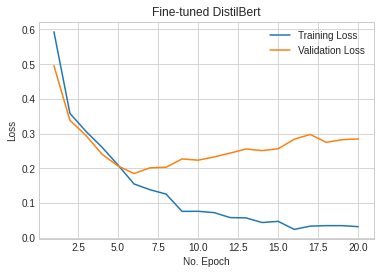

In [ ]:
history = pd.read_csv(output_dir+'/train_history_log',sep='\t')

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(6,4))
plt.plot(history['Epoch'], history['Training Loss'], label='Training Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel("No. Epoch")
plt.ylabel("Loss")
plt.title("Fine-tuned DistilBert")
plt.legend()
plt.savefig(output_dir+'/train_history_plot.png', dpi=300)
plt.show()

# Evaluation

Let's load up the trained model (if not already loaded)

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other']
NUM_LABELS = len(label_names)
# Loading the checkpoint with the best validation loss (checkpoint-408)
path_to_model_dir = output_dir
model = DistilBertForMultilabelSequenceClassification.from_pretrained(
    path_to_model_dir, 
    num_labels=NUM_LABELS,
    id2label=dict(enumerate(label_names)), # use to show text labels
)

Set it to evaluation mode --

In [ ]:
model.eval()

DistilBertForMultilabelSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

## Qualitative Evaluation (Simple Predictions for Text Queries)

In [ ]:
# Convert token to vocabulary indices
some_queries = ["what information do you collect?",  # label: 'first'
                "are you certified to be secure?",   # label: 'datasecurity'
                "who can read the chat i have with the platform?",   # labels: ['first',	'third']
                ]

def predict_labels(model, query):
    labels = np.array(['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other'])
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor(tokenizer([query], truncation=True, padding=True)['input_ids'])
    model.eval()
    tokens_tensor.to('cpu')
    model.to('cpu')
    probabilities = torch.sigmoid(model(tokens_tensor)[0][0])
    bool_pred = np.array([True if p > 0.5 else False for p in probabilities])
    label_pred = labels[bool_pred].tolist()
    return label_pred

for query in some_queries:
    print(predict_labels(model, query))

['first']
['datasecurity']
['first', 'third']


Let's check for consistency/robustness --

In [ ]:
print(predict_labels(model, "will other companies have access to my info?"))
print(predict_labels(model, "will other companies have access to my information?"))
print(predict_labels(model, "will other companies have access to my information?"))
print(predict_labels(model, "will other entities see my data?"))
print(predict_labels(model, "will other entities see my info?"))
print(predict_labels(model, "will other companies see my data?"))
print()
print(predict_labels(model, "will you allow me to remove data?"))
print(predict_labels(model, "will you let me remove stuff?"))
print(predict_labels(model, "will you let me remove everything?"))
print()
print(predict_labels(model, "could I delete my data?"))
print(predict_labels(model, "will I be able to delete my information?"))
print()
print(predict_labels(model, "will you keep my information forever?"))
print(predict_labels(model, "What will you do to my information?"))
print(predict_labels(model, "What will you do to my data?"))

['first', 'third']
['first', 'third']
['first', 'third']
['third']
['first', 'third']
['third']

[]
[]
[]

['user_access']
['user_access']

['dataretention']
['first']
['first']


We can see that small changes to the input will sometimes affect the model's output. We wanna see if we can make the model more robust to these changes by adding adversarial examples to the data.

## Quantitative Evaluation

Let's do a quick check to see that the model is indeed the one that performed best on the validation set (i.e. a loss of ~0.2) --

In [ ]:
evaluator = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=val_dataset,             # evaluation dataset
)

eval_results = evaluator.evaluate()
print()
for key in ['eval_loss']:
    value = eval_results[key]
    if type(value) != type(np.array([])):
        print(f'{key}:', value)
    else:
        print(f'{key}:\n')
        for lab, val in zip(label_names, value): 
            print(f'{lab}:', val)
    print()


eval_loss: 0.18529579043388367



Get the predictions and ground truths --

In [ ]:
model.to('cpu')

# Plot normalized confusion matrix (values in [0,1])
def predict_one_hot(model, input_tokens):
    # Convert inputs to PyTorch tensors
    model.to('cpu')
    probabilities = torch.sigmoid(model(input_tokens)[0][0])
    one_hot_pred = np.array([1 if p > 0.5 else 0 for p in probabilities])
    return one_hot_pred

# produce one-hot preds 
y_true = val_dataset[:]['labels'].tolist()
y_pred = torch.sigmoid(model(val_dataset[:]['input_ids'])[0]).round().detach().numpy().astype('int32').tolist()

## Confusion Matrix

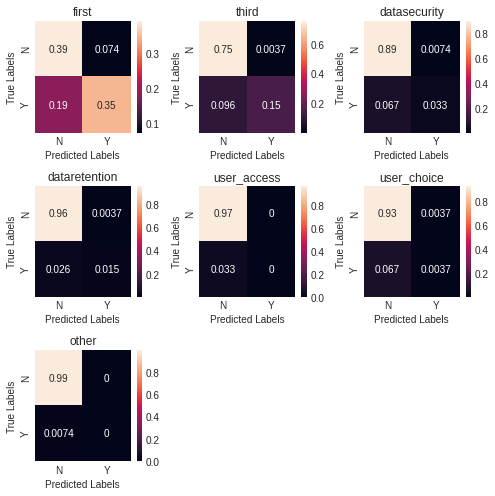

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other']
con_mat = multilabel_confusion_matrix(y_true, y_pred) / len(y_true)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7,7))
for i, ax in enumerate(axes.flat):
    if i < 7:
        con_mat_df = pd.DataFrame(con_mat[i], index=['N', 'Y'], columns=['N', 'Y'])    
        sns.heatmap(con_mat_df, annot=True, ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(label_names[i])
    else:
        ax.set_visible(False)

plt.tight_layout() 
plt.savefig(output_dir+'/confusion_matrices.png', dpi=300)
plt.show()

## Evaluate the model with the following metrics: accuracy, F1 score, precision, and recall.

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention', 'user_access', 'user_choice', 'other']
# Print and save classification report
print('Validation F1 Accuracy: ', f1_score(y_true, y_pred,average='micro'))
print('Validation Flat Accuracy: ', accuracy_score(y_true, y_pred),'\n')
clf_report = classification_report(y_true, y_pred, target_names=label_names)
pickle.dump(clf_report, open(output_dir+'/classification_report.txt','wb')) #save report
print(clf_report)

Validation F1 Accuracy:  0.656319290465632
Validation Flat Accuracy:  0.5222222222222223 

               precision    recall  f1-score   support

        first       0.82      0.65      0.73       144
        third       0.98      0.61      0.75        66
 datasecurity       0.82      0.33      0.47        27
dataretention       0.80      0.36      0.50        11
  user_access       0.00      0.00      0.00         9
  user_choice       0.50      0.05      0.10        19
        other       0.00      0.00      0.00         2

    micro avg       0.86      0.53      0.66       278
    macro avg       0.56      0.29      0.36       278
 weighted avg       0.80      0.53      0.63       278
  samples avg       0.51      0.49      0.49       278



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
